## Tunable Compression Autoencoder

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import random
import math

import tensorflow_datasets as tfds
from tensorflow import keras 
from keras import layers
from keras import backend as K

## MNIST Dataset

In [518]:
# Prepare the dataset. We use both the training & test MNIST digits.

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))

print(np.shape(all_digits))
print(np.shape(x_train))
print(np.shape(x_test))

batch_size = 128

dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size = 1024).batch(batch_size)

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size = 1024).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_dataset = test_dataset.shuffle(buffer_size = 1024).batch(batch_size)

(70000, 28, 28, 1)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


## Model

In [552]:
from keras.layers.convolutional.conv2d_transpose import Conv2DTranspose
from keras.layers.reshaping.up_sampling2d import UpSampling2D

input_shape = (28,28,1)

latent_dim = 128

# encoder 
encoder = keras.Sequential()
encoder.add(keras.Input(shape = input_shape))
encoder.add(layers.Conv2D(128, (2,2), padding = 'same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.MaxPooling2D((2,2),padding = 'same'))

encoder.add(layers.Conv2D(64, (2,2), activation = 'relu', padding = 'same'))
encoder.add(layers.Activation('relu'))
encoder.add(layers.MaxPooling2D((2,2),padding = 'same'))

encoder.add(layers.Flatten())
encoder.add(layers.Dense(latent_dim, activation = 'relu'))

encoder.summary()

decoder = keras.Sequential()
decoder.add(keras.Input(shape = (latent_dim,)))
decoder.add(layers.Dense(7*7*64, activation = 'relu'))
decoder.add(layers.Reshape(target_shape = (7,7,64)))

decoder.add(Conv2DTranspose(64, (2,2), padding = 'same'))
decoder.add(layers.Activation('relu'))
decoder.add(UpSampling2D((2,2)))

decoder.add(Conv2DTranspose(128, (2,2), padding = 'same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))
decoder.add(UpSampling2D((2,2)))

decoder.add(Conv2DTranspose(1, (2,2), padding = 'same'))
decoder.add(layers.Activation('sigmoid'))


decoder.summary()


Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_86 (Conv2D)          (None, 28, 28, 128)       640       
                                                                 
 batch_normalization_73 (Bat  (None, 28, 28, 128)      512       
 chNormalization)                                                
                                                                 
 activation_185 (Activation)  (None, 28, 28, 128)      0         
                                                                 
 max_pooling2d_85 (MaxPoolin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_87 (Conv2D)          (None, 14, 14, 64)        32832     
                                                                 
 activation_186 (Activation)  (None, 14, 14, 64)     

In [553]:
class TCAE(keras.Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.avg_loss_tracker = keras.metrics.Mean(name = 'avg_loss')

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer 
        self.loss_fn = loss_fn

    def train_step(self, data):

        avg_loss = 0

        for i in range(int(np.log2(latent_dim)+1)):

            with tf.GradientTape() as tape:
                # create mask
                ones_length = int(2**(np.log2(latent_dim)-i))
                zeros_length = int(latent_dim - ones_length)
                ones = tf.ones((ones_length)) 
                zeros = tf.zeros((zeros_length))
                mask = tf.concat([ones, zeros], axis = 0) 
                mask = tf.reshape(mask, (1,latent_dim))
     
                codes = self.encoder(data)
                masked_codes = tf.multiply(codes, mask)
                #print(codes.shape)
                #print(mask.shape)
                #print(masked_codes.shape)
                #masked_codes = tf.reshape(masked_codes, (tf.shape(codes)[0], latent_dim))
                
                reconstruction = self.decoder(masked_codes)

                loss = self.loss_fn(data, reconstruction)
            
            avg_loss += loss
            # get gradients
            grads = tape.gradient(loss, self.trainable_weights)
            # apply gradients
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        avg_loss = avg_loss / int(np.log2(latent_dim)+1)
            
        self.avg_loss_tracker.update_state(avg_loss)

        return {
            'avg_loss': self.avg_loss_tracker.result()
        }

    def custom_predict(self, data, n):

        # create mask
        ones_length = int(2**(n))
        zeros_length = int(latent_dim - ones_length)
        ones = tf.ones((ones_length)) 
        zeros = tf.zeros((zeros_length))
        mask = tf.concat([ones, zeros], axis = 0) 
        mask = tf.reshape(mask, (1,latent_dim))

        codes = self.encoder(data)
        masked_codes = tf.multiply(codes, mask)
        #masked_codes = tf.reshape(masked_codes, (1, latent_dim))
        
        reconstruction = self.decoder(masked_codes)

        return reconstruction

    def test_step(self, data):
        
        avg_loss = 0

        for i in range(int(np.log2(latent_dim)+1)):
            # create mask
            ones_length = int(2**(np.log2(latent_dim)-i))
            zeros_length = int(latent_dim - ones_length)
            ones = tf.ones((ones_length)) 
            zeros = tf.zeros((zeros_length))
            mask = tf.concat([ones, zeros], axis = 0) 
            mask = tf.reshape(mask, (1,latent_dim))

            # mask codes
            codes = self.encoder(data)
            masked_codes = tf.multiply(codes, mask)        
            reconstruction = self.decoder(masked_codes)

            loss = self.loss_fn(data, reconstruction)
            
            avg_loss += loss

        avg_loss = avg_loss / int(np.log2(latent_dim)+1)
            
        self.avg_loss_tracker.update_state(avg_loss)

        return {
            'avg_loss': self.avg_loss_tracker.result()
        }


        



In [555]:
# test masking 

i = 5

ones_length = int(2**(i))
zeros_length = int(latent_dim - ones_length)
ones = tf.ones((ones_length)) 
zeros = tf.zeros((zeros_length))
mask = tf.concat([ones, zeros], axis = 0)
mask = tf.reshape(mask, (1, latent_dim,))

a = mask.numpy()
print(a)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]]


In [556]:
# initialize tcae

tcae = TCAE(encoder = encoder, decoder = decoder)
tcae.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss_fn = tf.keras.losses.BinaryCrossentropy())

In [557]:
epochs = 3

tcae.fit(train_dataset, epochs = epochs, validation_data = test_dataset)

Epoch 1/3
 28/469 [>.............................] - ETA: 17:55 - avg_loss: 0.2810

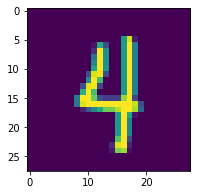

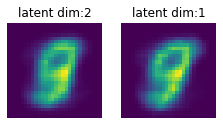

In [548]:
index = random.randint(0, np.shape(all_digits)[0]-1)
img = all_digits[index,:,:,0]

plt.figure(figsize = (3,3))
plt.imshow(img)

img = img.reshape(1, 28, 28, 1)

plt.figure(figsize = (16,5))
for i in range(int(np.log2(latent_dim))+1):
    ax = plt.subplot(2, 8, i + 1)
    reconstruction = tcae.custom_predict([img], np.log2(latent_dim)-i)
    reconstruction = reconstruction.numpy().reshape(28,28)
    plt.title('latent dim:{}'.format(int(2**(np.log2(latent_dim)-i))))
    plt.imshow(reconstruction)
    plt.axis('off')


